📁 Google Drive 마운트 중...
Mounted at /content/drive
✔ CSV 경로: /content/drive/MyDrive/receipt_model/receipts.csv

📌 원본 데이터 미리보기:
                     filename                  text category  price  \
0        20251113_알촌_8300.jpg           알촌 식비 8300원       식비   8300   
1   20251117_죠스아이스크림_1400.jpg  죠스아이스크림 편의점/마트 1400원   편의점/마트   1400   
2   20251117_죠스아이스크림_1500.jpg  죠스아이스크림 편의점/마트 1500원   편의점/마트   1500   
3  20251118_매머드익스프레스_1100.jpg     매머드익스프레스 카페 1100원       카페   1100   
4  20251118_매머드익스프레스_3400.jpg     매머드익스프레스 카페 3400원       카페   3400   

         date  
0  2025-11-13  
1  2025-11-17  
2  2025-11-17  
3  2025-11-18  
4  2025-11-18  

📌 데이터 개수: 27

=== 📌 데이터 분할 결과 ===
Train: 18
Validation: 4
Test: 5

=== 📌 모델 학습 & Validation Accuracy ===
Logistic Regression ➜ 1.0000
Linear SVM ➜ 1.0000
Naive Bayes ➜ 1.0000
Random Forest ➜ 1.0000

🎉 최고의 모델: Logistic Regression, Acc=1.0000


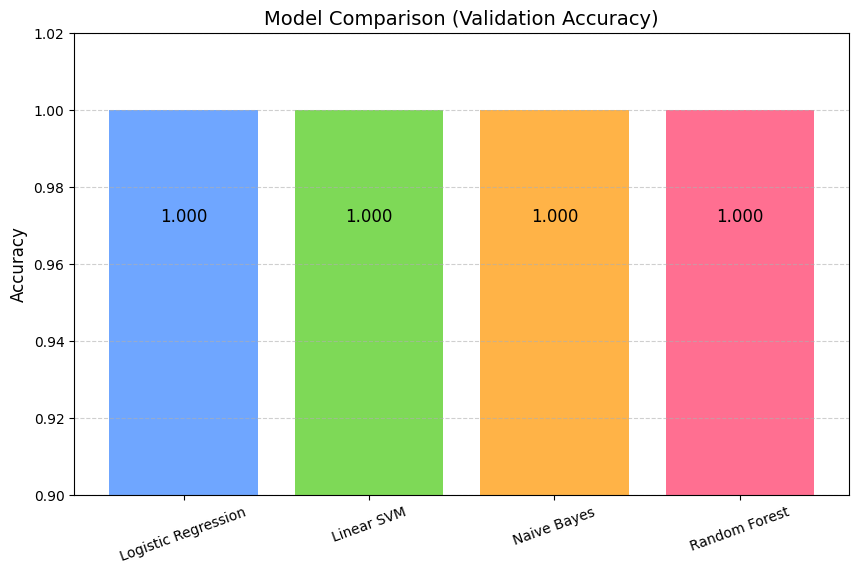

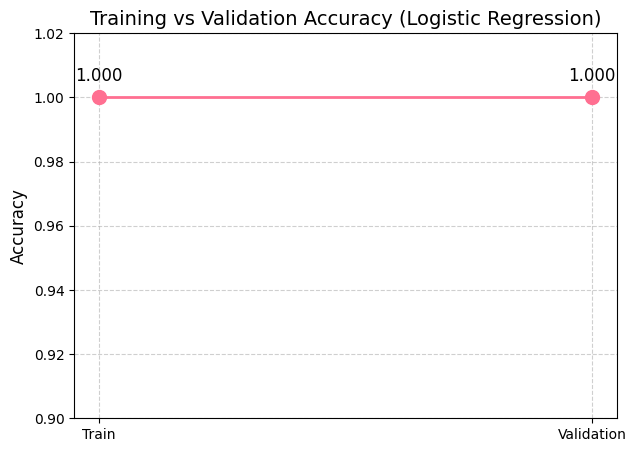


=== 📌 Test Accuracy (Best Model 기준) ===
Test Accuracy: 1.0

💾 모델 저장 완료!
모델 경로: /content/drive/MyDrive/receipt_model/model.pkl
벡터라이저 경로: /content/drive/MyDrive/receipt_model/vectorizer.pkl

🎉 Training Notebook 전체 완료!


In [59]:
# ===========================================
# 📌 Training Notebook (여러 모델 비교 + 저장 + 시각화)
# ===========================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
import joblib
from google.colab import drive

# ===========================================
# 1. Google Drive 마운트
# ===========================================
print("📁 Google Drive 마운트 중...")
drive.mount('/content/drive', force_remount=True)

drive_dir = "/content/drive/MyDrive/receipt_model"
os.makedirs(drive_dir, exist_ok=True)

csv_path = f"{drive_dir}/receipts.csv"
print("✔ CSV 경로:", csv_path)


# ===========================================
# 2. 데이터 로드
# ===========================================
df = pd.read_csv(csv_path)

print("\n📌 원본 데이터 미리보기:")
print(df.head())
print("\n📌 데이터 개수:", len(df))


# ===========================================
# 3. 데이터 분할 (⚠ stratify 제거)
# ===========================================
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42
)

print("\n=== 📌 데이터 분할 결과 ===")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")


# ===========================================
# 4. TF-IDF 벡터화
# ===========================================
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df["text"])
X_val   = vectorizer.transform(val_df["text"])
X_test  = vectorizer.transform(test_df["text"])

y_train = train_df["category"]
y_val = val_df["category"]
y_test = test_df["category"]


# ===========================================
# 5. 여러 모델 학습 및 비교
# ===========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": SVC(kernel='linear', probability=True),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

val_scores = {}

print("\n=== 📌 모델 학습 & Validation Accuracy ===")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    val_scores[name] = acc
    print(f"{name} ➜ {acc:.4f}")

# 최고 성능 모델 선정
best_model_name = max(val_scores, key=val_scores.get)
best_model = models[best_model_name]

print(f"\n🎉 최고의 모델: {best_model_name}, Acc={val_scores[best_model_name]:.4f}")


# ===========================================
# 6. 모델별 성능 비교 그래프
# ===========================================

plt.figure(figsize=(10, 6))

models_list = list(val_scores.keys())
scores_list = list(val_scores.values())

colors = ['#6FA6FF', '#7ED957', '#FFB347', '#FF6F91']  # 파스텔톤 색상 4개

bars = plt.bar(models_list, scores_list, color=colors)

plt.ylim(0.9, 1.02)   # 그래프를 보기 쉽게 (0.9~1.0)
plt.title("Model Comparison (Validation Accuracy)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 정확도 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height - 0.03,
        f"{height:.3f}",
        ha='center', va='bottom', fontsize=12, color="black"
    )

plt.xticks(rotation=20)
plt.show()



# ===========================================
# 7. 학습 및 검증 정확도 곡선
# ===========================================

plt.figure(figsize=(7,5))

train_acc = lr_model.score(X_train, y_train)
val_acc = lr_model.score(X_val, y_val)

plt.plot(["Train", "Validation"], [train_acc, val_acc],
         marker='o', markersize=10, linestyle='-', linewidth=2,
         color='#FF6F91', label="Accuracy")

plt.ylim(0.9, 1.02)
plt.title("Training vs Validation Accuracy (Logistic Regression)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 값 표시
plt.text(0, train_acc + 0.005, f"{train_acc:.3f}", ha='center', fontsize=12)
plt.text(1, val_acc + 0.005, f"{val_acc:.3f}", ha='center', fontsize=12)

plt.show()



# ===========================================
# 8. Test Accuracy 평가 (최고 모델 기준)
# ===========================================
test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)

print("\n=== 📌 Test Accuracy (Best Model 기준) ===")
print("Test Accuracy:", test_acc)


# ===========================================
# 9. 모델 + 벡터라이저 저장
# ===========================================
model_path = f"{drive_dir}/model.pkl"
vectorizer_path = f"{drive_dir}/vectorizer.pkl"

joblib.dump(best_model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print("\n💾 모델 저장 완료!")
print("모델 경로:", model_path)
print("벡터라이저 경로:", vectorizer_path)

print("\n🎉 Training Notebook 전체 완료!")
